In [2]:
# Model Experiments - Features Sets

# Model - Logistic Reg, Log Loss + Elastic Regularisation + SGD
# Features -
#     * All Channels - Raw, Abs, Mag (8)
#     * All Windows  - 0
#     * All Indiv    - nil
#     * All Pairwise -
#            - Synch - Correl, lag-Correl, MI, mimicry, Coherence and Granger's
#            - Convr - Sym.Conv, Asym.Conv, Glob.Conv
#     * All GroupFeat-
#            - Aggreagtion - Min, Max, Mean, Mode, Var
#            
# Evaluation - Acc, Conf.Matrix, AUC, Precision, Recall,

In [3]:
import sys  
sys.path.insert(0, '/Users/navinlr/Desktop/Thesis/code_base/conversation_quality')

In [4]:
from modeling import dataset_provider as data_gen
from feature_extract import turntake_extractor as tt_extractor
import feature_namer_script as feat_namers
import constants

from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, mean_squared_error, roc_auc_score, r2_score, explained_variance_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFE, chi2
from lightgbm import LGBMClassifier
from imblearn import under_sampling 
from imblearn import over_sampling
from sklearn.metrics import auc
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from scipy import stats
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd
sns.set(rc={'figure.figsize':(11.7,8.27)})

Total Groups = 115


/Users/navinlr/opt/anaconda3/envs/conversation_quality/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/navinlr/opt/anaconda3/envs/conversation_quality/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.5.
Set the environment variable OUTDATED_IGNORE=1 to disabl

In [5]:
# Variables for baseline
random_seed=44
manifest="indiv"
data_split_per=.40
missing_data_thresh=50.0 #(in percent)
convq_thresh=3.0
agreeability_thresh=.2
annotators=["Divya", "Nakul"]#, "Swathi"]
only_involved_pairs=True
use_tt_features=False
splits = 5
store_file=constants.indiv_tt_X_path
if manifest=="group":
    smote_nn = 2
else:
    smote_nn = 6

tt_features = ["conv_eq", "#turns", "%talk", "mean_turn", "mean_silence", "%silence", "#bc", "%overlap", "#suc_interupt", "#un_interupt"]

label_type = "hard"
model_type = "log-elastic"
feat_sel = "anova"
zero_mean  = False

datasets=[constants.features_dataset_path_v7,
          constants.features_dataset_path_v13,
          "tt-indiv"]
dataset_feat=[feat_namers.get_feature_names_for_dataset_7,
              feat_namers.get_feature_names_for_dataset_13,
              feat_namers.get_feature_names_for_tt]

In [6]:
# Functions 
def over_sample_data(temp_X, temp_y, method="SMOTE", k_neighbors=6):
    if method == "SMOTE":
        temp_X, temp_y = SMOTE(k_neighbors=k_neighbors-1, random_state=random_seed).fit_resample(temp_X, temp_y)
    return temp_X, temp_y

def feature_normalize(temp_X, method="min-max"):
    # Fit on training set only.
    if method == "min-max":
        normaliser = MinMaxScaler().fit(temp_X)
    elif method == "mean-var":
        normaliser = StandardScaler().fit(temp_X)
    return normaliser
    
def feature_selection(temp_X, temp_y, method="anova", num_feats=None):
    top_features = []
    if method == "anova":
        f_values, p_values = f_classif(temp_X, temp_y)
        threshold=np.median(np.absolute(np.array(f_values)))*num_feats
        top_features=np.where(np.absolute(np.array(f_values)) >= threshold)[0]
#         top_features=np.where(np.absolute(np.array(p_values)) <= 0.5)[0]
    elif method == "tree-based":
        sel_model = SelectFromModel(RandomForestClassifier(n_estimators=100, class_weight='balanced'),
                                    max_features=num_feats, threshold=-np.inf).fit(temp_X, temp_y)
        top_features = sel_model.get_support(True)
    elif method == "rec-elim":
        sel_model = RFE(estimator=LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced'),
                        n_features_to_select=num_feats, step=10000).fit(temp_X, temp_y)
        top_features = sel_model.get_support(True)
    elif method == "lgbc":
        lgbc = LGBMClassifier(n_estimators=1000, learning_rate=0.05)
        sel_model = SelectFromModel(lgbc, max_features=num_feats, threshold=-np.inf).fit(temp_X, temp_y)
        top_features = sel_model.get_support(True)

    return top_features

def select_required_features(temp_X, required_feats, method="anova"):
    if method == "anova":
        temp_X=temp_X[:,required_feats]
#     elif method
    return temp_X

def dimension_reduction(temp_X, method="pca", threshold_var=0.95):
    dim_red_model = None
    if method=="pca":
        dim_red_model = PCA(threshold_var).fit(temp_X)
    elif method=="tsne":
        dim_red_model = TSNE(n_components=2).fit(temp_X)
    return dim_red_model
    
def process_convq_labels(y, label_type="soft"):
    print("Data-type of labels - " + str(type(y)))
    if label_type=="soft":
        y=list(np.around(np.array(y),2))
    else:
        y=list(np.where(np.array(y) <= convq_thresh, 0, 1))
        print("ConvQ Classes Distribution : (Total = "+ str(len(y)) +")")
        print("High Quality Conv = " + str(sum(y)))
        print("Low Quality Conv = " + str(len(y)-sum(y)))
    return y

def model_convq_manifestation(temp_X, temp_y, model="log-reg", fit=True):
    
    if fit:
        if model == "log-reg":
            model = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced').fit(temp_X, temp_y)
        elif model == "lin-reg":
            model = LinearRegression().fit(temp_X, temp_y)
        elif model == "adaboost":
            model = AdaBoostClassifier(n_estimators=500).fit(temp_X, temp_y)
        elif model == "dec-tree":
            model = DecisionTreeClassifier(class_weight='balanced').fit(temp_X, temp_y)
        elif model == "rand-for":
            model = RandomForestClassifier(n_estimators=1000, class_weight='balanced').fit(temp_X, temp_y)
        elif model == "svm":
            model = SVC(kernel='poly').fit(temp_X, temp_y)
        elif model == "log-elastic":
            model = SGDClassifier(loss="log", class_weight="balanced", penalty="elasticnet",
                                  learning_rate='adaptive', eta0=0.001,
                                  max_iter=10000).fit(temp_X, temp_y)
        elif model == "grad-boost-quant":
            model = GradientBoostingRegressor(loss='quantile',n_estimators=1000).fit(temp_X, temp_y)
    else:
        if model == "log-reg":
            model = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced')
        elif model == "lin-reg":
            model = LinearRegression()
        elif model == "adaboost":
            model = AdaBoostClassifier(n_estimators=500)
        elif model == "dec-tree":
            model = DecisionTreeClassifier(class_weight='balanced')
        elif model == "rand-for":
            model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
        elif model == "svm":
            model = SVC(kernel='poly')
        elif model == "log-elastic":
            model = SGDClassifier(loss="log", max_iter=10000, class_weight='balanced')
        elif model == "grad-boost-quant":
            model = GradientBoostingRegressor(loss='quantile',n_estimators=1000)
    return model

def get_model_predict_proba(temp_X, model):
    return model.predict_proba(temp_X)[::,1]

def analyse_model_params(model):
    return True

def test_model(temp_X, model):
    return model.predict(temp_X)

def evaluate_predict(test_temp_y, predict_temp_y, method=accuracy_score):
    score = method(test_temp_y, predict_temp_y)
    return score

In [16]:
# Experiment List
experiments=["Turn-Taking \n Features", "Synchrony \n Features",
             "Convergence \n Features", 
             "Synchrony + \n Convergence",
             "Causality \n Features",
             "Synchrony + \n Convergence \n + Causality \n (Body Coordination)",
             "Turn-Taking + \n Body Coordination", 
             "Turn-Taking + \n Synchrony + \n Convergence"]

In [8]:
# Data Read
auc_experiment_dict={}
X=[]
feat_namer=[]
for w, curr_dataset in enumerate(datasets):
    
    if "tt" in curr_dataset:
        curr_X = tt_extractor.get_tt_dataset_feats_for(ids, tt_features, manifest)
    else:
        curr_X, y, ids = data_gen.get_dataset_for_experiment(dataset=curr_dataset,
                                                            manifest=manifest,
                                                            missing_data_thresh=missing_data_thresh,
                                                            agreeability_thresh=agreeability_thresh,
                                                            annotators=annotators,
                                                            only_involved_pairs=only_involved_pairs,
                                                            zero_mean=zero_mean)
    
    if len(X) == 0:
        X=curr_X
        feat_namer=dataset_feat[w]()
    else:
        X=np.concatenate((X, curr_X), axis=1) 
        feat_namer.extend(dataset_feat[w]())
        
    print("Current Feature Set - " + str(X.shape))
# Label Prep
# Hard/Soft Labels
y = process_convq_labels(y, label_type)

features_df=pd.DataFrame(np.array(X), columns=feat_namer)

Generating Dataset for modeling - indiv ConvQ, ...........
Number of Groups (After removing missing data) - 85
ZERO-MEAN Technique ? - False
ZERO-MEAN Technique ? - False


21it [00:00, 208.49it/s]

Number of Final Data-points (After removing unreliable annotation data) - 179


179it [00:00, 190.18it/s]


Total #Features = 756
Current Feature Set - (179, 756)
Generating Dataset for modeling - indiv ConvQ, ...........
Number of Groups (After removing missing data) - 85
ZERO-MEAN Technique ? - False
ZERO-MEAN Technique ? - False


86it [00:00, 858.53it/s]

Number of Final Data-points (After removing unreliable annotation data) - 179


179it [00:00, 847.37it/s]
  0%|          | 0/179 [00:00<?, ?it/s]

Total #Features = 126
Current Feature Set - (179, 882)
For Sample ->>>> 1_005_13


  1%|          | 1/179 [00:01<03:49,  1.29s/it]

For Sample ->>>> 1_018_20


  1%|          | 2/179 [00:02<03:29,  1.18s/it]

For Sample ->>>> 1_018_31


  2%|▏         | 3/179 [00:03<03:14,  1.10s/it]

For Sample ->>>> 1_018_35


  2%|▏         | 4/179 [00:04<03:06,  1.07s/it]

For Sample ->>>> 1_019_17


  3%|▎         | 5/179 [00:05<03:11,  1.10s/it]

For Sample ->>>> 1_019_25


  3%|▎         | 6/179 [00:06<03:05,  1.07s/it]

For Sample ->>>> 1_030_17


  4%|▍         | 7/179 [00:07<03:05,  1.08s/it]

For Sample ->>>> 1_030_28


  4%|▍         | 8/179 [00:08<03:01,  1.06s/it]

For Sample ->>>> 1_033_13


  5%|▌         | 9/179 [00:09<02:57,  1.04s/it]

For Sample ->>>> 1_033_36


  6%|▌         | 10/179 [00:10<02:57,  1.05s/it]

For Sample ->>>> 1_034_17


  6%|▌         | 11/179 [00:11<03:06,  1.11s/it]

For Sample ->>>> 1_034_19


  7%|▋         | 12/179 [00:12<03:11,  1.14s/it]

For Sample ->>>> 1_034_25


  7%|▋         | 13/179 [00:14<03:14,  1.17s/it]

For Sample ->>>> 1_034_28


  8%|▊         | 14/179 [00:15<03:36,  1.31s/it]

For Sample ->>>> 1_035_12


  8%|▊         | 15/179 [00:17<03:41,  1.35s/it]

For Sample ->>>> 1_035_13


  9%|▉         | 16/179 [00:18<03:48,  1.40s/it]

For Sample ->>>> 1_042_16


  9%|▉         | 17/179 [00:20<03:37,  1.34s/it]

For Sample ->>>> 1_042_18


 10%|█         | 18/179 [00:21<03:25,  1.28s/it]

For Sample ->>>> 1_046_12


 11%|█         | 19/179 [00:22<03:19,  1.25s/it]

For Sample ->>>> 1_046_13


 11%|█         | 20/179 [00:23<03:09,  1.19s/it]

For Sample ->>>> 1_046_36


 12%|█▏        | 21/179 [00:24<03:00,  1.14s/it]

For Sample ->>>> 1_047_12


 12%|█▏        | 22/179 [00:25<02:38,  1.01s/it]

For Sample ->>>> 1_047_36


 13%|█▎        | 23/179 [00:25<02:24,  1.08it/s]

For Sample ->>>> 1_061_12


 13%|█▎        | 24/179 [00:26<02:28,  1.05it/s]

For Sample ->>>> 1_061_36


 14%|█▍        | 25/179 [00:27<02:29,  1.03it/s]

For Sample ->>>> 1_062_20


 15%|█▍        | 26/179 [00:29<03:00,  1.18s/it]

For Sample ->>>> 1_062_31


 15%|█▌        | 27/179 [00:31<03:25,  1.35s/it]

For Sample ->>>> 1_062_34


 16%|█▌        | 28/179 [00:32<03:35,  1.43s/it]

For Sample ->>>> 1_062_35


 16%|█▌        | 29/179 [00:34<03:39,  1.46s/it]

For Sample ->>>> 1_066_20


 17%|█▋        | 30/179 [00:35<03:13,  1.30s/it]

For Sample ->>>> 1_066_31


 17%|█▋        | 31/179 [00:36<02:56,  1.19s/it]

For Sample ->>>> 1_066_35


 18%|█▊        | 32/179 [00:37<02:44,  1.12s/it]

For Sample ->>>> 1_067_17


 18%|█▊        | 33/179 [00:38<02:48,  1.15s/it]

For Sample ->>>> 1_067_19


 19%|█▉        | 34/179 [00:39<02:49,  1.17s/it]

For Sample ->>>> 1_067_25


 20%|█▉        | 35/179 [00:40<02:53,  1.21s/it]

For Sample ->>>> 1_068_2


 20%|██        | 36/179 [00:42<02:52,  1.21s/it]

For Sample ->>>> 1_068_13


 21%|██        | 37/179 [00:43<02:51,  1.21s/it]

For Sample ->>>> 1_068_18


 21%|██        | 38/179 [00:44<02:50,  1.21s/it]

For Sample ->>>> 1_068_24


 22%|██▏       | 39/179 [00:45<02:49,  1.21s/it]

For Sample ->>>> 1_069_38


 22%|██▏       | 40/179 [00:46<02:23,  1.03s/it]

For Sample ->>>> 1_069_39


 23%|██▎       | 41/179 [00:47<02:05,  1.10it/s]

For Sample ->>>> 1_071_20


 23%|██▎       | 42/179 [00:48<02:28,  1.09s/it]

For Sample ->>>> 1_071_31


 24%|██▍       | 43/179 [00:50<02:45,  1.21s/it]

For Sample ->>>> 1_071_34


 25%|██▍       | 44/179 [00:51<02:58,  1.32s/it]

For Sample ->>>> 1_072_8


 25%|██▌       | 45/179 [00:52<02:28,  1.11s/it]

For Sample ->>>> 1_072_26


 26%|██▌       | 46/179 [00:52<02:07,  1.04it/s]

For Sample ->>>> 1_073_26


 26%|██▋       | 47/179 [00:53<01:53,  1.16it/s]

For Sample ->>>> 1_074_8


 27%|██▋       | 48/179 [00:54<01:43,  1.27it/s]

For Sample ->>>> 1_075_8


 27%|██▋       | 49/179 [00:54<01:35,  1.36it/s]

For Sample ->>>> 1_075_26


 28%|██▊       | 50/179 [00:55<01:30,  1.42it/s]

For Sample ->>>> 1_076_14


 28%|██▊       | 51/179 [00:55<01:26,  1.48it/s]

For Sample ->>>> 1_076_32


 29%|██▉       | 52/179 [00:56<01:23,  1.52it/s]

For Sample ->>>> 1_077_14


 30%|██▉       | 53/179 [00:57<01:21,  1.55it/s]

For Sample ->>>> 1_077_32


 30%|███       | 54/179 [00:57<01:19,  1.57it/s]

For Sample ->>>> 1_078_14


 31%|███       | 55/179 [00:58<01:17,  1.59it/s]

For Sample ->>>> 1_078_32


 31%|███▏      | 56/179 [00:59<01:16,  1.61it/s]

For Sample ->>>> 1_079_14


 32%|███▏      | 57/179 [00:59<01:15,  1.61it/s]

For Sample ->>>> 1_079_32


 32%|███▏      | 58/179 [01:00<01:14,  1.62it/s]

For Sample ->>>> 1_080_16


 33%|███▎      | 59/179 [01:00<01:14,  1.62it/s]

For Sample ->>>> 1_080_21


 34%|███▎      | 60/179 [01:01<01:13,  1.62it/s]

For Sample ->>>> 1_081_16


 34%|███▍      | 61/179 [01:02<01:12,  1.63it/s]

For Sample ->>>> 1_081_21


 35%|███▍      | 62/179 [01:02<01:11,  1.63it/s]

For Sample ->>>> 1_082_18


 35%|███▌      | 63/179 [01:03<01:10,  1.63it/s]

For Sample ->>>> 1_083_2


 36%|███▌      | 64/179 [01:03<01:10,  1.64it/s]

For Sample ->>>> 1_083_18


 36%|███▋      | 65/179 [01:04<01:09,  1.64it/s]

For Sample ->>>> 1_084_16


 37%|███▋      | 66/179 [01:05<01:08,  1.64it/s]

For Sample ->>>> 1_084_21


 37%|███▋      | 67/179 [01:05<01:08,  1.64it/s]

For Sample ->>>> 1_085_16


 38%|███▊      | 68/179 [01:06<01:07,  1.64it/s]

For Sample ->>>> 1_085_21


 39%|███▊      | 69/179 [01:07<01:07,  1.63it/s]

For Sample ->>>> 1_086_20


 39%|███▉      | 70/179 [01:08<01:26,  1.26it/s]

For Sample ->>>> 1_086_31


 40%|███▉      | 71/179 [01:09<01:39,  1.09it/s]

For Sample ->>>> 1_086_34


 40%|████      | 72/179 [01:10<01:47,  1.01s/it]

For Sample ->>>> 1_086_35


 41%|████      | 73/179 [01:11<01:54,  1.08s/it]

For Sample ->>>> 1_087_20


 41%|████▏     | 74/179 [01:13<01:57,  1.12s/it]

For Sample ->>>> 1_087_31


 42%|████▏     | 75/179 [01:14<01:59,  1.15s/it]

For Sample ->>>> 1_087_34


 42%|████▏     | 76/179 [01:15<02:00,  1.17s/it]

For Sample ->>>> 1_087_35


 43%|████▎     | 77/179 [01:16<02:00,  1.18s/it]

For Sample ->>>> 1_088_12


 44%|████▎     | 78/179 [01:17<01:41,  1.01s/it]

For Sample ->>>> 1_088_36


 44%|████▍     | 79/179 [01:17<01:29,  1.12it/s]

For Sample ->>>> 1_089_2


 45%|████▍     | 80/179 [01:18<01:28,  1.11it/s]

For Sample ->>>> 1_089_13


 45%|████▌     | 81/179 [01:19<01:28,  1.11it/s]

For Sample ->>>> 1_089_18


 46%|████▌     | 82/179 [01:20<01:28,  1.10it/s]

For Sample ->>>> 1_090_19


 46%|████▋     | 83/179 [01:21<01:19,  1.20it/s]

For Sample ->>>> 1_090_25


 47%|████▋     | 84/179 [01:22<01:13,  1.30it/s]

For Sample ->>>> 1_091_17


 47%|████▋     | 85/179 [01:22<01:07,  1.38it/s]

For Sample ->>>> 1_091_28


 48%|████▊     | 86/179 [01:23<01:04,  1.45it/s]

For Sample ->>>> 2_006_12


 49%|████▊     | 87/179 [01:25<01:36,  1.05s/it]

For Sample ->>>> 2_006_15


 49%|████▉     | 88/179 [01:26<01:57,  1.30s/it]

For Sample ->>>> 2_006_33


 50%|████▉     | 89/179 [01:29<02:17,  1.53s/it]

For Sample ->>>> 2_009_23


 50%|█████     | 90/179 [01:29<01:53,  1.28s/it]

For Sample ->>>> 2_022_12


 51%|█████     | 91/179 [01:30<01:43,  1.17s/it]

For Sample ->>>> 2_022_33


 51%|█████▏    | 92/179 [01:31<01:38,  1.13s/it]

For Sample ->>>> 2_036_8


 52%|█████▏    | 93/179 [01:33<01:57,  1.37s/it]

For Sample ->>>> 2_036_9


 53%|█████▎    | 94/179 [01:35<02:16,  1.60s/it]

For Sample ->>>> 2_036_14


 53%|█████▎    | 95/179 [01:38<02:30,  1.80s/it]

For Sample ->>>> 2_036_16


 54%|█████▎    | 96/179 [01:40<02:42,  1.96s/it]

For Sample ->>>> 2_036_22


 54%|█████▍    | 97/179 [01:42<02:43,  1.99s/it]

For Sample ->>>> 2_036_35


 55%|█████▍    | 98/179 [01:44<02:39,  1.96s/it]

For Sample ->>>> 2_038_12


 55%|█████▌    | 99/179 [01:45<02:12,  1.66s/it]

For Sample ->>>> 2_038_33


 56%|█████▌    | 100/179 [01:46<01:53,  1.44s/it]

For Sample ->>>> 2_042_2


 56%|█████▋    | 101/179 [01:47<01:54,  1.47s/it]

For Sample ->>>> 2_042_7


 57%|█████▋    | 102/179 [01:49<01:54,  1.49s/it]

For Sample ->>>> 2_042_13


 58%|█████▊    | 103/179 [01:50<01:53,  1.50s/it]

For Sample ->>>> 2_042_15


 58%|█████▊    | 104/179 [01:52<01:54,  1.53s/it]

For Sample ->>>> 2_044_8


 59%|█████▊    | 105/179 [01:54<02:01,  1.64s/it]

For Sample ->>>> 2_044_9


 59%|█████▉    | 106/179 [01:56<02:04,  1.70s/it]

For Sample ->>>> 2_044_14


 60%|█████▉    | 107/179 [01:59<02:42,  2.25s/it]

For Sample ->>>> 2_044_16


 60%|██████    | 108/179 [02:02<02:41,  2.28s/it]

For Sample ->>>> 2_044_22


 61%|██████    | 109/179 [02:04<02:41,  2.31s/it]

For Sample ->>>> 2_044_30


 61%|██████▏   | 110/179 [02:06<02:36,  2.27s/it]

For Sample ->>>> 2_052_12


 62%|██████▏   | 111/179 [02:08<02:20,  2.06s/it]

For Sample ->>>> 2_052_13


 63%|██████▎   | 112/179 [02:09<02:05,  1.87s/it]

For Sample ->>>> 2_056_27


 63%|██████▎   | 113/179 [02:10<01:46,  1.62s/it]

For Sample ->>>> 2_056_28


 64%|██████▎   | 114/179 [02:12<01:41,  1.57s/it]

For Sample ->>>> 2_057_27


 64%|██████▍   | 115/179 [02:13<01:38,  1.54s/it]

For Sample ->>>> 2_058_5


 65%|██████▍   | 116/179 [02:14<01:20,  1.28s/it]

For Sample ->>>> 2_059_5


 65%|██████▌   | 117/179 [02:15<01:13,  1.19s/it]

For Sample ->>>> 2_060_9


 66%|██████▌   | 118/179 [02:17<01:32,  1.51s/it]

For Sample ->>>> 2_060_14


 66%|██████▋   | 119/179 [02:19<01:47,  1.79s/it]

For Sample ->>>> 2_060_22


 67%|██████▋   | 120/179 [02:22<01:52,  1.90s/it]

For Sample ->>>> 2_060_35


 68%|██████▊   | 121/179 [02:24<02:00,  2.08s/it]

For Sample ->>>> 2_061_8


 68%|██████▊   | 122/179 [02:26<02:01,  2.14s/it]

For Sample ->>>> 2_061_9


 69%|██████▊   | 123/179 [02:29<02:01,  2.16s/it]

For Sample ->>>> 2_061_16


 69%|██████▉   | 124/179 [02:31<02:07,  2.33s/it]

For Sample ->>>> 2_061_22


 70%|██████▉   | 125/179 [02:34<02:07,  2.36s/it]

For Sample ->>>> 2_064_2


 70%|███████   | 126/179 [02:35<01:54,  2.16s/it]

For Sample ->>>> 2_064_31


 71%|███████   | 127/179 [02:37<01:44,  2.00s/it]

For Sample ->>>> 2_065_2


 72%|███████▏  | 128/179 [02:39<01:35,  1.88s/it]

For Sample ->>>> 2_065_31


 72%|███████▏  | 129/179 [02:40<01:32,  1.86s/it]

For Sample ->>>> 2_066_13


 73%|███████▎  | 130/179 [02:41<01:18,  1.59s/it]

For Sample ->>>> 2_067_13


 73%|███████▎  | 131/179 [02:42<01:07,  1.40s/it]

For Sample ->>>> 2_067_15


 74%|███████▎  | 132/179 [02:43<01:00,  1.29s/it]

For Sample ->>>> 2_069_27


 74%|███████▍  | 133/179 [02:44<00:52,  1.13s/it]

For Sample ->>>> 2_069_28


 75%|███████▍  | 134/179 [02:45<00:44,  1.01it/s]

For Sample ->>>> 3_006_4


 75%|███████▌  | 135/179 [02:46<00:49,  1.12s/it]

For Sample ->>>> 3_006_9


 76%|███████▌  | 136/179 [02:48<00:54,  1.27s/it]

For Sample ->>>> 3_006_20


 77%|███████▋  | 137/179 [02:49<00:55,  1.31s/it]

For Sample ->>>> 3_006_23


 77%|███████▋  | 138/179 [02:51<00:54,  1.33s/it]

For Sample ->>>> 3_007_11


 78%|███████▊  | 139/179 [02:52<00:49,  1.25s/it]

For Sample ->>>> 3_007_12


 78%|███████▊  | 140/179 [02:53<00:46,  1.19s/it]

For Sample ->>>> 3_007_15


 79%|███████▉  | 141/179 [02:54<00:42,  1.12s/it]

For Sample ->>>> 3_012_14


 79%|███████▉  | 142/179 [02:55<00:42,  1.16s/it]

For Sample ->>>> 3_012_25


 80%|███████▉  | 143/179 [02:56<00:43,  1.20s/it]

For Sample ->>>> 3_021_20


 80%|████████  | 144/179 [02:57<00:41,  1.18s/it]

For Sample ->>>> 3_021_23


 81%|████████  | 145/179 [02:59<00:44,  1.30s/it]

For Sample ->>>> 3_029_9


 82%|████████▏ | 146/179 [03:00<00:43,  1.32s/it]

For Sample ->>>> 3_029_20


 82%|████████▏ | 147/179 [03:02<00:42,  1.33s/it]

For Sample ->>>> 3_029_23


 83%|████████▎ | 148/179 [03:03<00:41,  1.33s/it]

For Sample ->>>> 3_031_4


 83%|████████▎ | 149/179 [03:04<00:39,  1.31s/it]

For Sample ->>>> 3_031_20


 84%|████████▍ | 150/179 [03:06<00:38,  1.34s/it]

For Sample ->>>> 3_031_23


 84%|████████▍ | 151/179 [03:07<00:36,  1.29s/it]

For Sample ->>>> 3_033_31


 85%|████████▍ | 152/179 [03:08<00:34,  1.27s/it]

For Sample ->>>> 3_035_4


 85%|████████▌ | 153/179 [03:09<00:33,  1.31s/it]

For Sample ->>>> 3_035_9


 86%|████████▌ | 154/179 [03:11<00:34,  1.40s/it]

For Sample ->>>> 3_035_20


 87%|████████▋ | 155/179 [03:13<00:36,  1.51s/it]

For Sample ->>>> 3_035_23


 87%|████████▋ | 156/179 [03:14<00:34,  1.51s/it]

For Sample ->>>> 3_037_4


 88%|████████▊ | 157/179 [03:15<00:30,  1.37s/it]

For Sample ->>>> 3_037_20


 88%|████████▊ | 158/179 [03:16<00:26,  1.26s/it]

For Sample ->>>> 3_037_23


 89%|████████▉ | 159/179 [03:17<00:23,  1.19s/it]

For Sample ->>>> 3_041_4


 89%|████████▉ | 160/179 [03:19<00:23,  1.24s/it]

For Sample ->>>> 3_041_9


 90%|████████▉ | 161/179 [03:20<00:23,  1.29s/it]

For Sample ->>>> 3_041_20


 91%|█████████ | 162/179 [03:22<00:22,  1.30s/it]

For Sample ->>>> 3_041_23


 91%|█████████ | 163/179 [03:23<00:21,  1.32s/it]

For Sample ->>>> 3_048_7


 92%|█████████▏| 164/179 [03:24<00:16,  1.13s/it]

For Sample ->>>> 3_048_24


 92%|█████████▏| 165/179 [03:24<00:13,  1.00it/s]

For Sample ->>>> 3_050_9


 93%|█████████▎| 166/179 [03:25<00:11,  1.10it/s]

For Sample ->>>> 3_050_20


 93%|█████████▎| 167/179 [03:26<00:10,  1.18it/s]

For Sample ->>>> 3_051_4


 94%|█████████▍| 168/179 [03:26<00:08,  1.24it/s]

For Sample ->>>> 3_051_23


 94%|█████████▍| 169/179 [03:27<00:07,  1.28it/s]

For Sample ->>>> 3_058_14


 95%|█████████▍| 170/179 [03:28<00:06,  1.29it/s]

For Sample ->>>> 3_058_25


 96%|█████████▌| 171/179 [03:29<00:06,  1.33it/s]

For Sample ->>>> 3_064_3


 96%|█████████▌| 172/179 [03:29<00:05,  1.36it/s]

For Sample ->>>> 3_064_29


 97%|█████████▋| 173/179 [03:30<00:04,  1.33it/s]

For Sample ->>>> 3_065_3


 97%|█████████▋| 174/179 [03:31<00:03,  1.35it/s]

For Sample ->>>> 3_065_29


 98%|█████████▊| 175/179 [03:31<00:02,  1.37it/s]

For Sample ->>>> 3_066_3


 98%|█████████▊| 176/179 [03:32<00:02,  1.38it/s]

For Sample ->>>> 3_066_29


 99%|█████████▉| 177/179 [03:33<00:01,  1.38it/s]

For Sample ->>>> 3_068_15


 99%|█████████▉| 178/179 [03:34<00:00,  1.37it/s]

For Sample ->>>> 3_069_15


100%|██████████| 179/179 [03:34<00:00,  1.20s/it]

Current Feature Set - (179, 892)
Data-type of labels - <class 'list'>
ConvQ Classes Distribution : (Total = 179)
High Quality Conv = 163
Low Quality Conv = 16


In [9]:
# TT Gather
tt_feats=[]
for f in feat_namer:
    if "tt-" in f or "#un_interupt" in f:
        tt_feats.extend([f])

# Sync Gather
sync_feats=[]
for f in feat_namer:
    if "corr-" in f or "mi-" in f or "mimicry-" in f:
        sync_feats.extend([f])

# Conv Gather
conv_feats=[]
for f in feat_namer:
    if "conv-" in f:
        conv_feats.extend([f])

#Sync + Conv
sync_conv_feats=list(sync_feats)
sync_conv_feats.extend(conv_feats)
        
# Caus Gather
caus_feats=[]
for f in feat_namer:
    if "granger-" in f or "coherence-" in f:
        caus_feats.extend([f])
        
# ALL-Sync Gather
all_sync_feats=list(sync_feats)
all_sync_feats.extend(conv_feats)
all_sync_feats.extend(caus_feats)

# Fuse Gather
fused_feats=list(all_sync_feats)
fused_feats.extend(tt_feats)

# TT + Sync + Conv Gather
b3_feats=list(sync_feats)
b3_feats.extend(conv_feats)
b3_feats.extend(tt_feats)
 
print("Number of Turn-Taking Features = " + str(len(tt_feats)))
print("Number of Synchrony Features = " + str(len(sync_feats)))
print("Number of Convergence Features = " + str(len(conv_feats)))
print("Number of Synchrony + Convergence Features = " + str(len(sync_conv_feats)))

print("Number of Causality Features = " + str(len(caus_feats)))

print("Number of Coordination Features = " + str(len(all_sync_feats)))

print("Number of Fused Features = " + str(len(fused_feats)))
print("Number of Best 3 = " + str(len(b3_feats)))


feat_stack=[tt_feats,
            sync_feats,
            conv_feats,
            sync_conv_feats,
            caus_feats,
            all_sync_feats,
            fused_feats,
            b3_feats]

print(len(feat_stack))
print(len(experiments))

Number of Turn-Taking Features = 10
Number of Synchrony Features = 588
Number of Convergence Features = 168
Number of Synchrony + Convergence Features = 756
Number of Causality Features = 126
Number of Coordination Features = 882
Number of Fused Features = 892
Number of Best 3 = 766
8
8




~~ !! @@ @@ @@ @@ Current Feature-Set = Turn-Taking 
 Features ~~ !! @@ @@ @@ @@
After PCA Feature Set - (143, 6)
After anova Feature Set - (143, 4)
Train Data -> Features - (260, 4) and Labels - 260
Test  Data -> Features - (36, 4) and Labels - 36
130
After PCA Feature Set - (143, 6)
After anova Feature Set - (143, 4)
Train Data -> Features - (260, 4) and Labels - 260
Test  Data -> Features - (36, 4) and Labels - 36
130
After PCA Feature Set - (143, 7)
After anova Feature Set - (143, 5)
Train Data -> Features - (260, 5) and Labels - 260
Test  Data -> Features - (36, 5) and Labels - 36
130
After PCA Feature Set - (143, 6)
After anova Feature Set - (143, 4)
Train Data -> Features - (262, 4) and Labels - 262
Test  Data -> Features - (36, 4) and Labels - 36
131
After PCA Feature Set - (144, 6)
After anova Feature Set - (144, 4)
Train Data -> Features - (262, 4) and Labels - 262
Test  Data -> Features - (35, 4) and Labels - 35
131


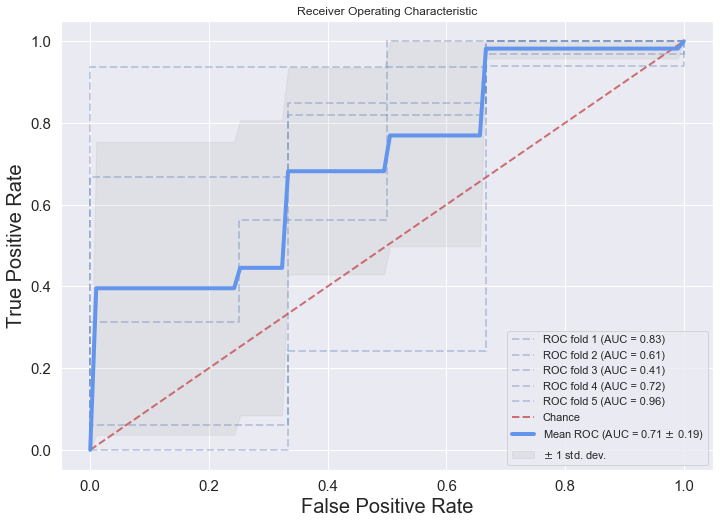

[0.8282828282828283, 0.6060606060606061, 0.41414141414141425, 0.71875, 0.9583333333333334]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[  8   8]
 [ 41 122]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Synchrony 
 Features ~~ !! @@ @@ @@ @@
After PCA Feature Set - (143, 53)
After anova Feature Set - (143, 15)
Train Data -> Features - (260, 15) and Labels - 260
Test  Data -> Features - (36, 15) and Labels - 36
130
After PCA Feature Set - (143, 52)
After anova Feature Set - (143, 8)
Train Data -> Features - (260, 8) and Labels - 260
Test  Data -> Features - (36, 8) and Labels - 36
130
After PCA Feature Set - (143, 51)
After anova Feature Set - (143, 9)
Train Data -> Features - (260, 9) and Labels - 260
Test  Data -> Features - (36, 9) and Labels - 36
130
After PCA Feature Set - (143, 52)
After anova Feature Set - (143, 9)
Train Data -> Features - (262, 9) and Labels - 262
Test  Data -> Features - (36, 9) and Labels - 36
131
After PCA Feature Set - (144, 52)
After anova Feature Set - (144, 17)

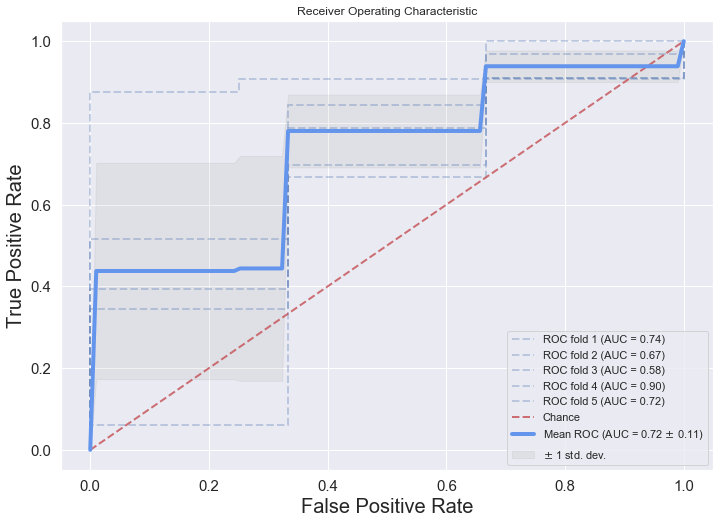

[0.7373737373737373, 0.6666666666666666, 0.5757575757575758, 0.8984375, 0.7187500000000001]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[ 10   6]
 [ 39 124]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Convergence 
 Features ~~ !! @@ @@ @@ @@
After PCA Feature Set - (143, 31)
After anova Feature Set - (143, 8)
Train Data -> Features - (260, 8) and Labels - 260
Test  Data -> Features - (36, 8) and Labels - 36
130
After PCA Feature Set - (143, 33)
After anova Feature Set - (143, 8)
Train Data -> Features - (260, 8) and Labels - 260
Test  Data -> Features - (36, 8) and Labels - 36
130
After PCA Feature Set - (143, 31)
After anova Feature Set - (143, 9)
Train Data -> Features - (260, 9) and Labels - 260
Test  Data -> Features - (36, 9) and Labels - 36
130
After PCA Feature Set - (143, 31)
After anova Feature Set - (143, 11)
Train Data -> Features - (262, 11) and Labels - 262
Test  Data -> Features - (36, 11) and Labels - 36
131
After PCA Feature Set - (144, 31)
After anova Feature Set - (144, 

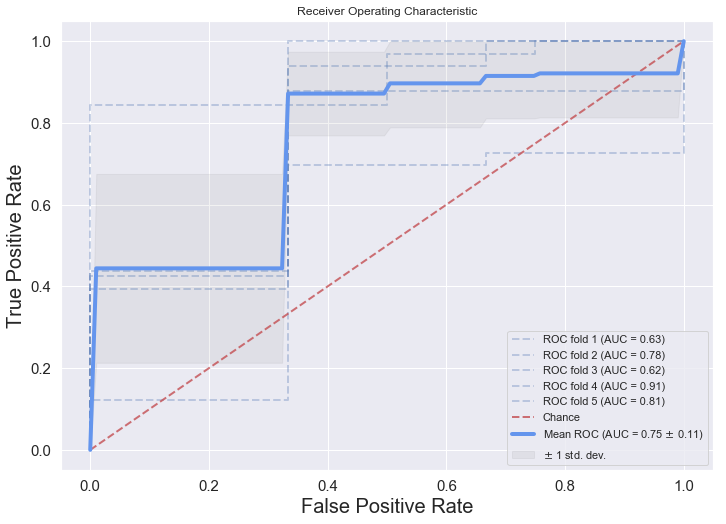

[0.6262626262626264, 0.7777777777777778, 0.6161616161616162, 0.9140625, 0.8125]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[ 10   6]
 [ 48 115]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Synchrony + 
 Convergence ~~ !! @@ @@ @@ @@
After PCA Feature Set - (143, 63)
After anova Feature Set - (143, 37)
Train Data -> Features - (260, 37) and Labels - 260
Test  Data -> Features - (36, 37) and Labels - 36
130
After PCA Feature Set - (143, 64)
After anova Feature Set - (143, 39)
Train Data -> Features - (260, 39) and Labels - 260
Test  Data -> Features - (36, 39) and Labels - 36
130
After PCA Feature Set - (143, 62)
After anova Feature Set - (143, 37)
Train Data -> Features - (260, 37) and Labels - 260
Test  Data -> Features - (36, 37) and Labels - 36
130
After PCA Feature Set - (143, 63)
After anova Feature Set - (143, 35)
Train Data -> Features - (262, 35) and Labels - 262
Test  Data -> Features - (36, 35) and Labels - 36
131
After PCA Feature Set - (144, 63)
After anova Feature Set - (144, 

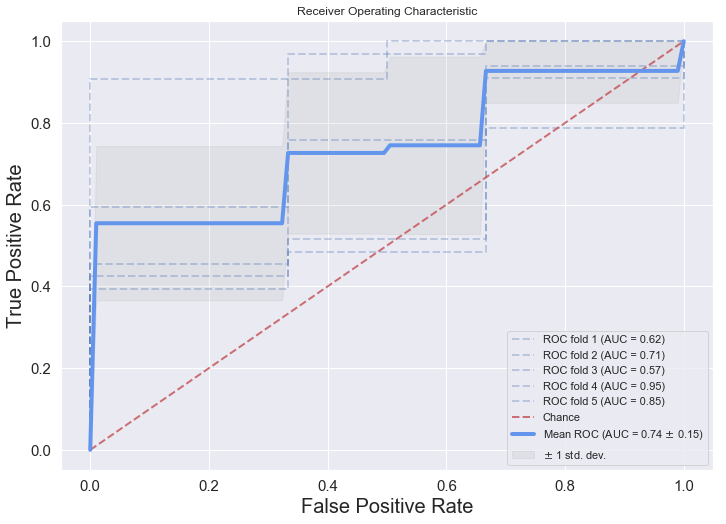

[0.6161616161616161, 0.7070707070707072, 0.5656565656565656, 0.953125, 0.8541666666666666]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[  8   8]
 [ 29 134]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Causality 
 Features ~~ !! @@ @@ @@ @@
After PCA Feature Set - (143, 29)
After anova Feature Set - (143, 7)
Train Data -> Features - (260, 7) and Labels - 260
Test  Data -> Features - (36, 7) and Labels - 36
130
After PCA Feature Set - (143, 28)
After anova Feature Set - (143, 9)
Train Data -> Features - (260, 9) and Labels - 260
Test  Data -> Features - (36, 9) and Labels - 36
130
After PCA Feature Set - (143, 28)
After anova Feature Set - (143, 8)
Train Data -> Features - (260, 8) and Labels - 260
Test  Data -> Features - (36, 8) and Labels - 36
130
After PCA Feature Set - (143, 28)
After anova Feature Set - (143, 11)
Train Data -> Features - (262, 11) and Labels - 262
Test  Data -> Features - (36, 11) and Labels - 36
131
After PCA Feature Set - (144, 28)
After anova Feature Set - (144, 6)


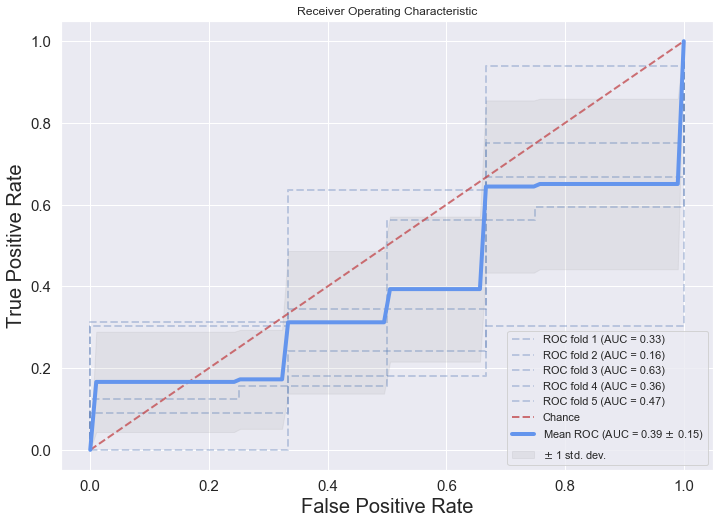

[0.33333333333333337, 0.16161616161616163, 0.6262626262626263, 0.359375, 0.46875]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[ 5 11]
 [68 95]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Synchrony + 
 Convergence + 
 Causality 
 (Body Coordination) ~~ !! @@ @@ @@ @@
After PCA Feature Set - (143, 70)
After anova Feature Set - (143, 8)
Train Data -> Features - (260, 8) and Labels - 260
Test  Data -> Features - (36, 8) and Labels - 36
130
After PCA Feature Set - (143, 70)
After anova Feature Set - (143, 19)
Train Data -> Features - (260, 19) and Labels - 260
Test  Data -> Features - (36, 19) and Labels - 36
130
After PCA Feature Set - (143, 69)
After anova Feature Set - (143, 16)
Train Data -> Features - (260, 16) and Labels - 260
Test  Data -> Features - (36, 16) and Labels - 36
130
After PCA Feature Set - (143, 70)
After anova Feature Set - (143, 14)
Train Data -> Features - (262, 14) and Labels - 262
Test  Data -> Features - (36, 14) and Labels - 36
131
After PCA Feature Set - (144, 70)
A

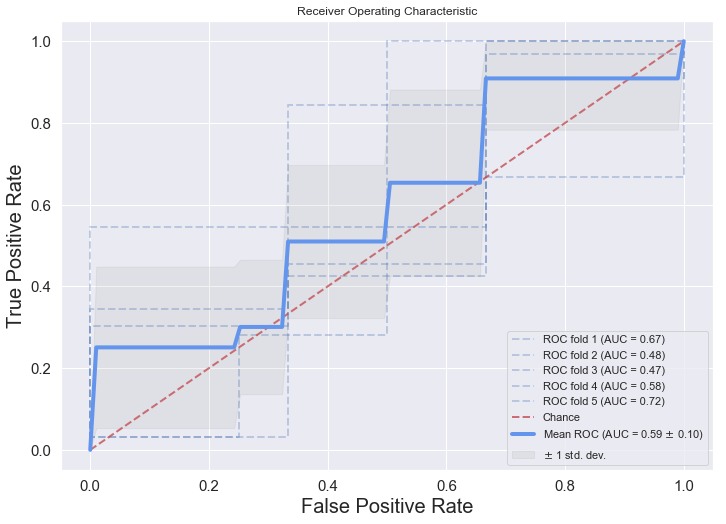

[0.6666666666666666, 0.48484848484848486, 0.4747474747474747, 0.578125, 0.7187500000000001]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[  5  11]
 [ 32 131]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Turn-Taking + 
 Body Coordination ~~ !! @@ @@ @@ @@
After PCA Feature Set - (143, 71)
After anova Feature Set - (143, 17)
Train Data -> Features - (260, 17) and Labels - 260
Test  Data -> Features - (36, 17) and Labels - 36
130
After PCA Feature Set - (143, 71)
After anova Feature Set - (143, 16)
Train Data -> Features - (260, 16) and Labels - 260
Test  Data -> Features - (36, 16) and Labels - 36
130
After PCA Feature Set - (143, 71)
After anova Feature Set - (143, 22)
Train Data -> Features - (260, 22) and Labels - 260
Test  Data -> Features - (36, 22) and Labels - 36
130
After PCA Feature Set - (143, 71)
After anova Feature Set - (143, 16)
Train Data -> Features - (262, 16) and Labels - 262
Test  Data -> Features - (36, 16) and Labels - 36
131
After PCA Feature Set - (144, 71)
After anova 

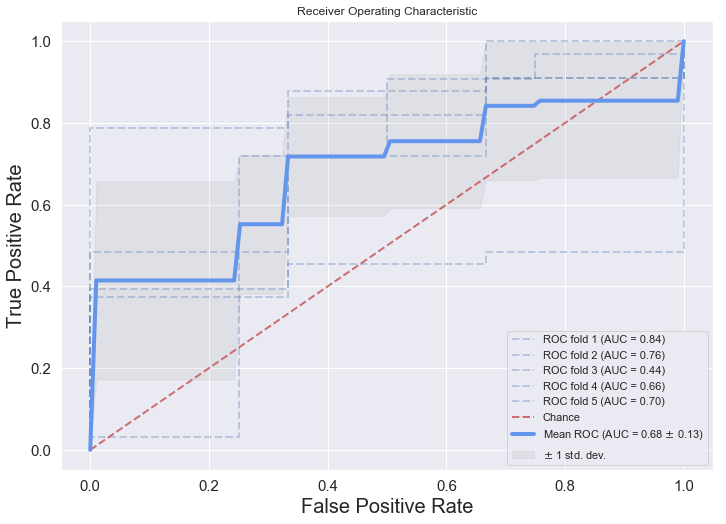

[0.8383838383838382, 0.7575757575757576, 0.4444444444444444, 0.65625, 0.6979166666666667]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[  5  11]
 [ 26 137]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Turn-Taking + 
 Synchrony + 
 Convergence ~~ !! @@ @@ @@ @@
After PCA Feature Set - (143, 64)
After anova Feature Set - (143, 15)
Train Data -> Features - (260, 15) and Labels - 260
Test  Data -> Features - (36, 15) and Labels - 36
130
After PCA Feature Set - (143, 65)
After anova Feature Set - (143, 15)
Train Data -> Features - (260, 15) and Labels - 260
Test  Data -> Features - (36, 15) and Labels - 36
130
After PCA Feature Set - (143, 64)
After anova Feature Set - (143, 12)
Train Data -> Features - (260, 12) and Labels - 260
Test  Data -> Features - (36, 12) and Labels - 36
130
After PCA Feature Set - (143, 64)
After anova Feature Set - (143, 15)
Train Data -> Features - (262, 15) and Labels - 262
Test  Data -> Features - (36, 15) and Labels - 36
131
After PCA Feature Set - (144, 64)
After 

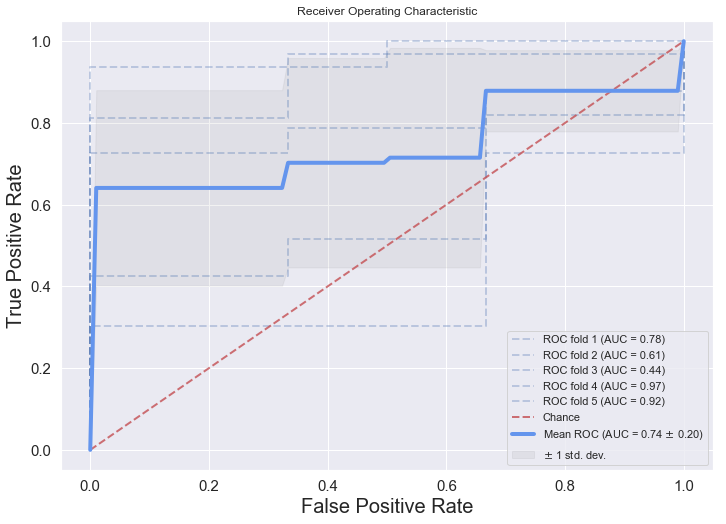

[0.7777777777777778, 0.6060606060606061, 0.4444444444444445, 0.96875, 0.9166666666666667]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[ 10   6]
 [ 34 129]]


In [11]:
feat_sel_threshold=[0.5, 3, 3, 0.5, 3, 3, 3, 3]
auc_experiment_dict={}

for f, curr_stack in enumerate(feat_stack):
#     print(features_df)
    experiment_feats=curr_stack
    
    print()
    print()
    print("~~ !! @@ @@ @@ @@ Current Feature-Set = " + str(experiments[f]) + " ~~ !! @@ @@ @@ @@")

    final_conf_matrix = [[0,0],[0,0]]
    final_auc_score = 0.0
    final_r_squared = 0.0
    final_expl_vari = 0.0
    iterative_auc = 0.0
    final_predict = []
    final_pred_prob = []
    final_label = []
    cv_auc_scores = []


    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()

    # Setup Features 
    X=features_df.loc[:,experiment_feats].values
    
    skf = StratifiedKFold(n_splits=5)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):

        # Data Prep
        train_X, test_X  = X[train_index], X[test_index]
        train_y, test_y  = [y[i] for i in train_index], [y[i] for i in test_index]

        # Transform Features
        normaliser = feature_normalize(train_X, method="mean-var")
        # Apply transform to both the training set and the test set.
        train_X = normaliser.transform(train_X)
        test_X  = normaliser.transform(test_X)

        # Dimensionality Reduction
        dimension_model = dimension_reduction(train_X, method="pca")
        train_X = dimension_model.transform(train_X)
        test_X  = dimension_model.transform(test_X)

        print("After " + "PCA" + " Feature Set - " + str(train_X.shape))

        # Feature Selection
        top_features = feature_selection(train_X, train_y, method=feat_sel, num_feats=feat_sel_threshold[f])
        train_X = select_required_features(train_X, top_features) 
        test_X  = select_required_features(test_X, top_features) 

        print("After " + feat_sel + " Feature Set - " + str(train_X.shape))


        # SAMPLING
        train_X, train_y = over_sample_data(train_X, train_y, method="SMOTE", k_neighbors=smote_nn)

        print("Train Data -> Features - " + str(train_X.shape) + " and Labels - " + str(len(train_y)))
        print("Test  Data -> Features - " + str(test_X.shape) + " and Labels - " + str(len(test_y)))
        print(str(sum(train_y))) 

        # Modelling
        classifier         = model_convq_manifestation(train_X, train_y, model_type, fit=True)        
        predict_y          = test_model(test_X, classifier) 


        final_conf_matrix = final_conf_matrix + evaluate_predict(test_y, predict_y, confusion_matrix)

        # CV ROC Plot
        viz = plot_roc_curve(classifier, test_X, test_y,
                         name='ROC fold {}'.format(i+1),
                         alpha=0.3, lw=2, linestyle='--', color='b', ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='cornflowerblue',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=4, alpha=1.0)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.1,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.tick_params(labelsize=15)
    
    plt.show()

    print(aucs)
    auc_experiment_dict[experiments[f]]=aucs
    print("~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~")
    print(final_conf_matrix)

In [12]:
all_values=[]
all_keys=[]
print(len(auc_experiment_dict.keys()))
print(len(experiments))
for i, k in enumerate(auc_experiment_dict.keys()):
    val=auc_experiment_dict[k]
#     if i !=0:
#         val=[x+.1 for x in val]
    all_values.extend(val)
    text=experiments[i]

    all_keys.extend([text] * 5)

experiment_results=pd.DataFrame(
    {'values': all_values,
     'type': all_keys
    })

8
8


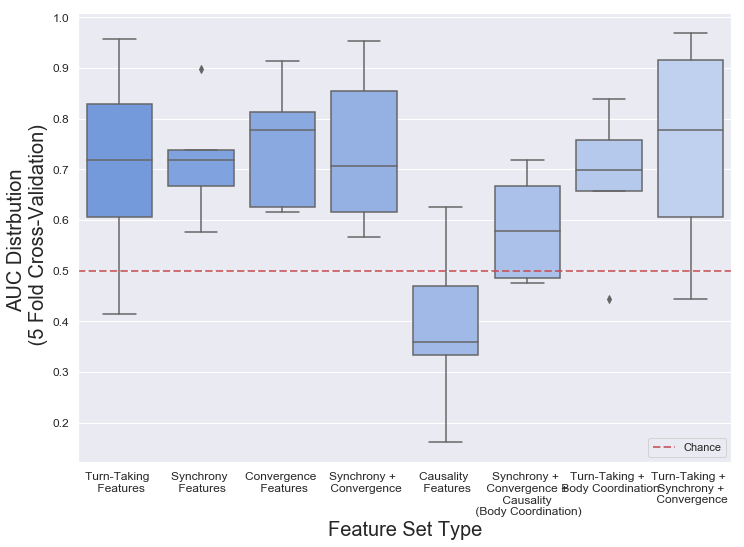

In [17]:
ax = sns.boxplot(x="type", y="values", data=experiment_results, palette=sns.light_palette("cornflowerblue", reverse=True, n_colors=12))

plt.ylabel('AUC Distrbution \n (5 Fold Cross-Validation)', fontsize=20)
plt.xlabel('Feature Set Type', fontsize=20)
plt.tick_params(labelsize=12)

# ax.plot(y=0.5, linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

plt.axhline(0.5, linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Might need to loop through the list if there are multiple lines on the plot
# ax.lines[0].set_linestyle("--")
# plt.plot(0.5)
plt.legend(loc="lower right")


plt.show()